## Argon!

In [90]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
%matplotlib inline

### constants

In [91]:
T = 1 #temperature in Kelvin
L = 3 #number of unit cells in 3 directions
Z = 4 #number of atoms per unit cell
N = Z*L**3 #number of atoms in total space
rho = 0.85 #density of particles
l = (Z/rho)**(1/3) #unit cell length in sigma

epsilon = 1 #normalized units
sigma = 1 

ld = L*l #computational domain length

M = 1 #39.948 * 1.660538921*10**(-27) #mass argon in kg
k = epsilon #boltzmann constatnt in SI units

### init position fcc

In [92]:
def init_pos(l):
    # particles in unit cell
    r = np.zeros(shape=(N, 3), dtype="float64")
    #coordinates of 4 particles in the unit cell
    p1 = l*np.array([0.25, 0.25, 0.25])
    p2 = l*np.array([0.75, 0.75, 0.25])
    p3 = l*np.array([0.75, 0.25, 0.75])
    p4 = l*np.array([0.25, 0.75, 0.75])

    # distribute all the particles by using the unit cell and displacing it in x y and z with length l
    n=0
    for x, y, z in product(range(L), range(L), range(L)):
        disp = np.multiply(l, np.array([x, y, z])) #displacement array
        r[n] = p1 + disp
        r[n + 1] = p2 + disp
        r[n + 2] = p3 + disp
        r[n + 3] = p4 + disp
        n += 4
        
    return r

### Init velocity

In [93]:
def init_vel(k,T,M,N):
    v = np.zeros(shape=(N, 3), dtype="float64")
    sigma = math.sqrt(k*T/M) #variance of the system
    mu = 0 #mean speed
    v = np.random.normal(mu, sigma, 3*N).reshape(-1, 3)
    v -= v.sum(axis=0) / N
    return v

### force algorithm

In [94]:
def FljArgon(r, ld):
    force=np.zeros(r.shape)
    #dr = math.sqrt(dx**2 + dy**2 + dz**2)
    epsilon = 1
    sigma = 1
    
    acc=np.zeros(shape=(N,3))
    V=0
    
    for i in range(N):
        for j in range(i):
            dx=r[i,0]-r[j,0]
            dy=r[i,1]-r[j,1]
            dz=r[i,2]-r[j,2]
            dx -= np.rint(dx / ld) * ld
            dy -= np.rint(dy / ld) * ld
            dz -= np.rint(dz / ld) * ld
            #dr=np.array([dx,dy,dz])
            dr2=dx*dx + dy*dy + dz*dz
            dr2 = 1/dr2
            dr6=dr2*dr2*dr2
            dr12=dr6*dr6
            dr14=dr12*dr2
            dr8=dr6*dr2
            V+=4*(dr12-dr6)
            force=24*(2*dr14-dr8)
            acc[i,0]+=force*dx
            acc[i,1]+=force*dy
            acc[i,2]+=force*dz
            acc[j,0]-=acc[i,0]
            acc[j,1]-=acc[i,1]
            acc[j,2]-=acc[i,2]
    
    return acc, V

### timestep function

In [95]:
def timestep(r,v,acc,dt):
    v += 0.5* acc * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r = np.mod(r , (ld)) #periodic boundary
    acc,V = FljArgon(r,ld) #forces due to new position
    v += 0.5 * acc * dt #complete velocity step
    
    return r,v,acc,V

## Energy calculation

In [96]:
Time = 100 #timesteps

Energy=np.zeros(shape=(Time,1))
Ve = np.zeros(shape=(Time,1))
K = np.zeros(shape=(Time,1))

dt = 0.004 #length of timestep

#initialize position and velocity, calculate force due to this position
r = init_pos(l)
v = init_vel(k,T,M,N)
acc,V = FljArgon(r,ld)


In [97]:
for i in range(Time):
    r, v, acc, V = timestep(r,v,acc,dt)
    v2=np.multiply(v,v)
    K[i]=0.5*np.sum(v2)
    Ve[i]= V
    Energy[i]=Ve[i]+K[i]

3.12157807367e+17


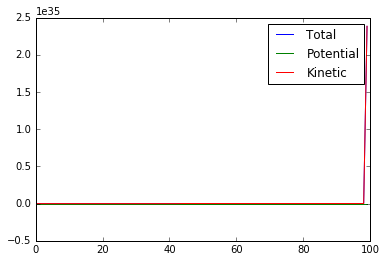

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Energy)
ax.plot(Ve)
ax.plot(K)
plt.legend(['Total','Potential','Kinetic'])
#ax.set_yscale('log')
#plt.ylim([1,10**1])
plt.show

print(V)